In [18]:
getwd()
list.files()

[1] "D:/Working_Space/R_Working/Autodesk_Adoption/first_week_report"

[1] "adjusted_basic_summary.R" "bar_graph"               
 [3] "basic_summary.R"          "business_size.R"         
 [5] "countries.R"              "custom functions.R"      
 [7] "data_preparation.R"       "dataset.RData"           
 [9] "Group_Analysis.R"         "histogram"               
[11] "percentage_age_users.R"   "percentage_bar"          
[13] "setup.R"                  "slide_page_5"            
[15] "top_products.R"           "Untitled.ipynb"

In [19]:
#run required R scripts
load("dataset.RData")
packages = c("tidyverse","stringr","lubridate","xlsx","forcats","RColorBrewer")
lapply(packages, require,character.only = TRUE)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

In [21]:
#download csv file to left join countries
country_codes <- read_csv("https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv")

Parsed with column specification:
cols(
  name = col_character(),
  `alpha-2` = col_character(),
  `alpha-3` = col_character(),
  `country-code` = col_character(),
  `iso_3166-2` = col_character(),
  region = col_character(),
  `sub-region` = col_character(),
  `region-code` = col_character(),
  `sub-region-code` = col_character()
)


In [23]:
#get the data to draw graph for differnt regions
region_seats_data <- dataset %>%
    filter(contract_status == "Active") %>%
    mutate(iso_country_alpha2_code = as.character(iso_country_alpha2_code)) %>%
    distinct(account_uuid,.keep_all = TRUE) %>%
    group_by(iso_country_alpha2_code,feature_name) %>%
    summarise(total_seats = sum(purchased_seat_quantity)) %>%
    left_join(country_codes,by = c("iso_country_alpha2_code" = "alpha-2")) %>%
    group_by(region,feature_name) %>%
    summarise(region_seats = sum(total_seats)) %>%
    filter(!is.na(region)) %>%
    ungroup() %>%
    mutate(region = as.factor(region)) %>%
    mutate(larger_region = fct_collapse(region,
                                        APAC = c("Asia","Oceania"),
                                        EMEA = c("Europe","Africa"),
                                        AMER = "Americas")) %>%
    mutate(abbr_feature_name = fct_recode(feature_name,
                                          "AEC" = "Architecture Engineering Construction Collection",
                                          "PD" = "Autodesk Product Design & Manufacturing Collection",
                                          "M&E" = "Media and Entertainment Collection")) %>%
    group_by(larger_region,abbr_feature_name) %>%
    select(larger_region, abbr_feature_name,region_seats) %>%
    group_by(larger_region,abbr_feature_name) %>%
    summarise(region_seats = sum(region_seats)) %>%
    ungroup();region_seats_data

larger_region,abbr_feature_name,region_seats
EMEA,AEC,22302
EMEA,PD,15314
EMEA,M&E,526
AMER,AEC,45595
AMER,PD,14447
AMER,M&E,857
APAC,AEC,17490
APAC,PD,6475
APAC,M&E,1517


In [24]:
#Calculate business size and its seats
business_size_seats <- dataset %>%
    filter(contract_status == "Active") %>%
    distinct(account_uuid,.keep_all = TRUE) %>%
    group_by(owner_id,feature_name) %>%
    summarise(total_seats = sum(purchased_seat_quantity)) %>% #How to define what is VSB,SMB AND ENT?
    ungroup() %>%
    #(0,2]-VSB, (10,100]-SMB, [100,Inf) - ENT
    mutate(business_size = cut(total_seats,breaks = c(0,2,100,Inf),labels = c("VSB","SMB","ENT"))) %>%
    group_by(feature_name,business_size) %>%
    summarise(total_seats = sum(total_seats)) %>%
    ungroup();business_size_seats

feature_name,business_size,total_seats
Architecture Engineering Construction Collection,VSB,24735
Architecture Engineering Construction Collection,SMB,56349
Architecture Engineering Construction Collection,ENT,4304
Autodesk Product Design & Manufacturing Collection,VSB,14448
Autodesk Product Design & Manufacturing Collection,SMB,20488
Autodesk Product Design & Manufacturing Collection,ENT,1300
Media and Entertainment Collection,VSB,824
Media and Entertainment Collection,SMB,1696
Media and Entertainment Collection,ENT,380


feature_name,business_size,total_seats,abbr_feature_name,percentage_seats,x,y,text,label
Architecture Engineering Construction Collection,VSB,24735,AEC,0.28967771,0,0.85516115,VSB 29%,n=85388
Architecture Engineering Construction Collection,SMB,56349,AEC,0.65991708,0,0.38036375,SMB 66%,n=85388
Architecture Engineering Construction Collection,ENT,4304,AEC,0.05040521,0,0.02520260,ENT 5%,n=85388
Autodesk Product Design & Manufacturing Collection,VSB,14448,PD,0.39871951,0,0.80064025,VSB 40%,n=36236
Autodesk Product Design & Manufacturing Collection,SMB,20488,PD,0.56540457,0,0.31857821,SMB 57%,n=36236
Autodesk Product Design & Manufacturing Collection,ENT,1300,PD,0.03587592,0,0.01793796,ENT 4%,n=36236
Media and Entertainment Collection,VSB,824,M&E,0.28413793,0,0.85793103,VSB 28%,n=2900
Media and Entertainment Collection,SMB,1696,M&E,0.58482759,0,0.42344828,SMB 58%,n=2900
Media and Entertainment Collection,ENT,380,M&E,0.13103448,0,0.06551724,ENT 13%,n=2900


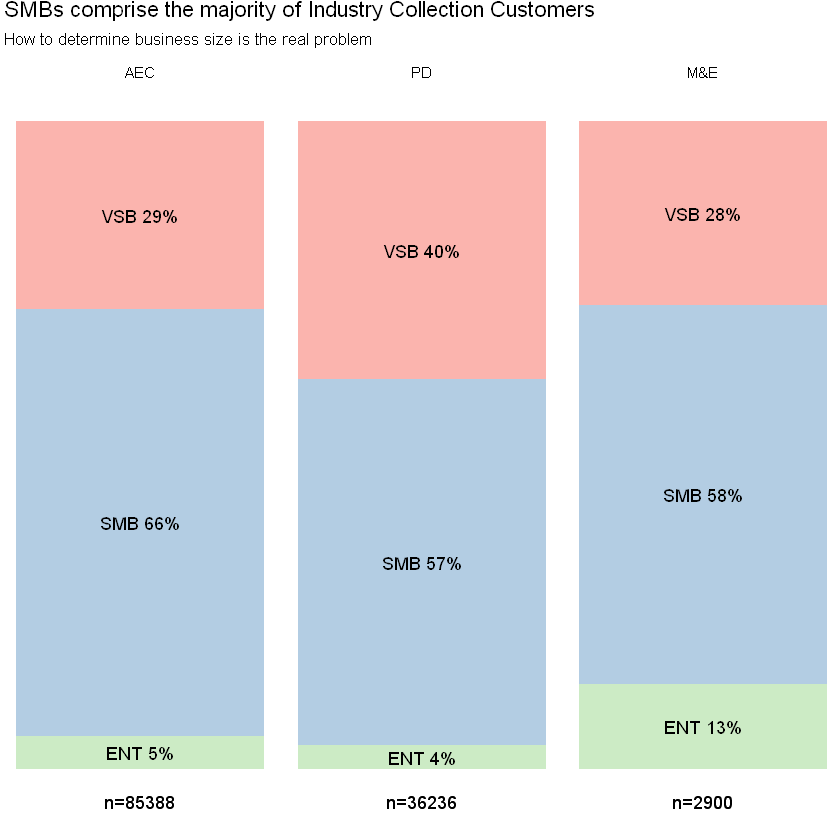

In [26]:
#Draw the plot

#Since company names are deleted, we can only infer business size with how many seats the company has.
#Howerver it's not accurate because, for example, a big company may only has a small department that needs
# the product collection.

data_for_plot <- business_size_seats %>%
    mutate(abbr_feature_name = fct_recode(feature_name,
                                          "AEC" = "Architecture Engineering Construction Collection",
                                          "PD" = "Autodesk Product Design & Manufacturing Collection",
                                          "M&E" = "Media and Entertainment Collection")) %>%
    group_by(abbr_feature_name) %>%
    mutate(percentage_seats = total_seats/sum(total_seats)) %>%
    ungroup() %>%
    #Add text for text
    mutate(x = 0, y = if_else(business_size == "VSB",(1 + (1-percentage_seats))/2,
                              if_else(business_size == "SMB",((1-lag(percentage_seats))+lead(percentage_seats))/2,
                                      (percentage_seats/2))),
           text = str_c(business_size, " ",round(percentage_seats,2)*100,"%")) %>%
    group_by(abbr_feature_name) %>%
    mutate(label = str_c("n=",sum(total_seats)));data_for_plot



data_for_plot %>%
    ggplot() +
    geom_col(mapping = aes(x = 0, y = percentage_seats, fill = business_size),position = "stack") + 
    geom_text(mapping = aes(x = 0, y = y, label = text)) +
    facet_grid(~abbr_feature_name) +
    labs(title = "SMBs comprise the majority of Industry Collection Customers",subtitle = "How to determine business size is the real problem") +
    geom_text(mapping = aes(x = 0, y = -0.05, label = label)) +
    theme_void() +
    theme(legend.position="none") +
    scale_fill_brewer( palette="Pastel1")